<a href="https://colab.research.google.com/github/balhyo-younjisang/Sejong_2024/blob/main/%EC%84%B8%EC%A2%85%EC%8B%9C_%EB%8F%84%EC%8B%9C%EC%97%B4%EC%84%AC%ED%9A%A8%EA%B3%BC_%EB%B0%A9%EC%A7%80_%EB%85%B9%EC%83%89_%EB%8F%84%EB%A1%9C_%EC%B5%9C%EC%A0%81_%EC%9E%85%EC%A7%80_%EC%84%A0%EC%A0%95_MCLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **필요 모듈 Import 및 폰트 설치**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install geopy folium

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123614 files and direc

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix
from numpy import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import json
from geopy.geocoders import Nominatim
import unicodedata


plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 세종시 자치구별 지면 데이터 시각화


In [ ]:
csv_path = "/content/gdrive/MyDrive/공모전/2024 세종시/작업_OBS_AWS_TIM_20240930184437.csv"
df = pd.read_csv(csv_path, encoding='cp949')
df['일시'] = pd.to_datetime(df['일시'])

# 고운, 전의 등 지점별 데이터 필터링
goun_data = df[df['지점'] == '고운']
jeonui_data = df[df['지점'] == '전의']
geumnam_data = df[df['지점'] == '금남']
yeonseo_data = df[df['지점'] == '연서']

goun_data.head()

,지점,일시,기온(°C)
0,고운,2023-01-01 01:00:00,-3.0
1,고운,2023-01-01 02:00:00,-3.5
2,고운,2023-01-01 03:00:00,-4.1
3,고운,2023-01-01 04:00:00,-4.7
4,고운,2023-01-01 05:00:00,-5.0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

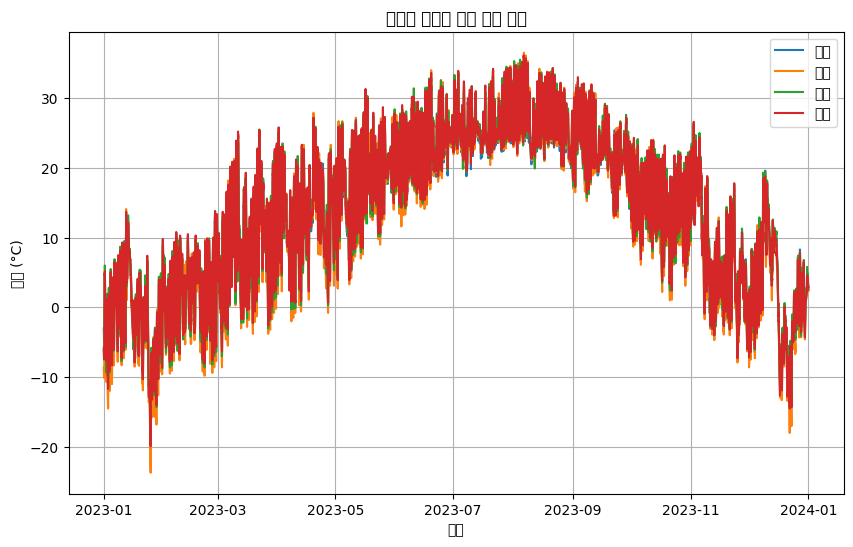

In [ ]:
# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 고운 지점의 기온 시각화
plt.plot(goun_data['일시'], goun_data['기온(°C)'], label='고운')

# 전의 지점의 기온 시각화
plt.plot(jeonui_data['일시'], jeonui_data['기온(°C)'], label='전의')

# 금남 지점의 기온 시각화
plt.plot(geumnam_data['일시'], geumnam_data['기온(°C)'], label='금남')

# 연서 지점의 기온 시각화
plt.plot(yeonseo_data['일시'], yeonseo_data['기온(°C)'], label='연서')

# 그래프 제목과 축 레이블 설정
plt.title('세종시 지점별 연간 기온 변화')
plt.xlabel('일시')
plt.ylabel('기온 (°C)')

# 범례와 그리드 추가
plt.legend()
plt.grid(True)

# 그래프 보여주기
plt.show()

In [ ]:
geo_path ='/content/gdrive/MyDrive/공모전/2024 세종시/hangjeongdong_세종특별자치시.geojson'
sejong_geo = json.load(open(geo_path, encoding='utf-8'))

with open(geo_path, 'r', encoding='utf-8') as f:
    geo_data = json.load(f)

# GeoJSON의 adm_nm 필드에서 유니코드 문자열 처리
for feature in geo_data['features']:
    # 유니코드 문자열을 변환하여 읽기 쉬운 형식으로 변경
    adm_nm = feature['properties']['adm_nm']
    feature['properties']['adm_nm'] = unicodedata.normalize('NFC', adm_nm)[12:14]

# 처리된 adm_nm 확인
print(geo_data['features'][12]['properties']['adm_nm'] == df['지점'][12])


daily_avg_temp = df.groupby(['지점', df['일시'].dt.date]).agg({'기온(°C)': 'mean'}).reset_index()
# 전체 평균 기온 계산
overall_avg_temp = daily_avg_temp.groupby('지점')['기온(°C)'].mean().reset_index()

print(overall_avg_temp.head())

# 세종시 중심 좌표 설정 (세종시청 근처)
sejong_center = [36.4800, 127.2890]

# 지도 생성
m = folium.Map(location=sejong_center, zoom_start=11)

# 구역별 기온 데이터를 기반으로 Choropleth 시각화
choropleth = folium.Choropleth(
    geo_data=geo_data,  # GeoJSON 데이터
    name='choropleth',
    data=overall_avg_temp,  # 기온 데이터 (행정구역별)
    columns=['지점', '기온(°C)'],  # 사용할 열 (지점, 기온 데이터)
    key_on='feature.properties.adm_nm',  # GeoJSON 내의 행정구역과 매칭
    fill_color='YlOrRd',  # 색상 스케일
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='세종시 행정구역별 기온'
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['adm_nm'], labels=False)
)

m

True
   지점     기온(°C)
0  고운  13.409352
1  금남  13.528922
2  연서  13.511137
3  전의  12.798558


# MCLP 알고리즘 적용

In [ ]:
!pip install pulp geopandas matplotlib shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 48.8 MB/s eta 0:00:00


Site_1에 녹지 통로 설치
Site_4에 녹지 통로 설치
Site_7에 녹지 통로 설치
Site_13에 녹지 통로 설치
Site_35에 녹지 통로 설치


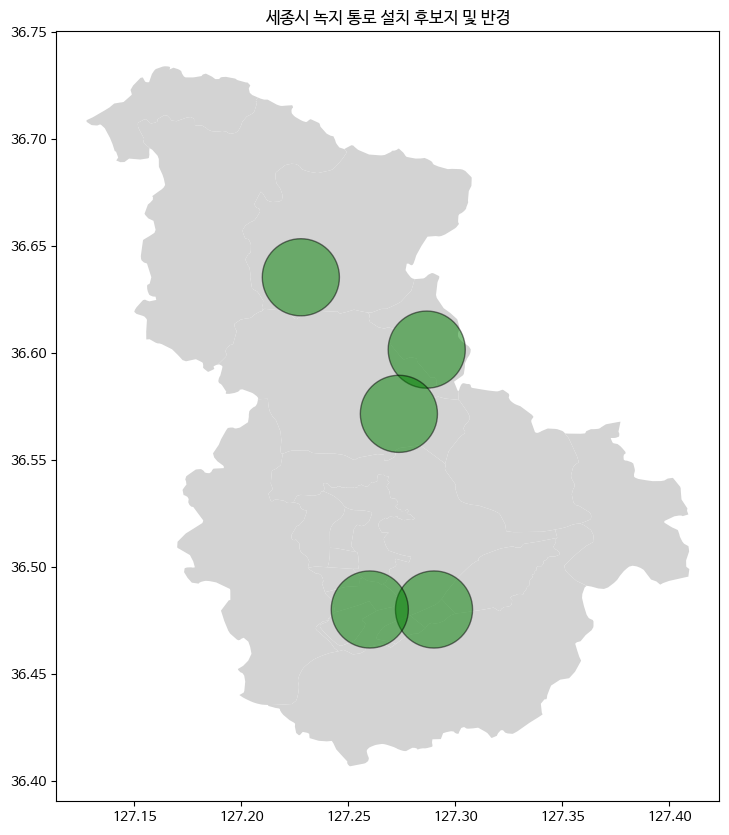

In [ ]:
import pulp
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopy.distance

# 1. 주요 지점 설정 (위도, 경도, 중요도)
locations = {
    'Jochiwon': {'lat': 36.6014, 'lon': 127.2866, 'demand': 100},  # 조치원읍
    'Yeongi': {'lat': 36.4802, 'lon': 127.2904, 'demand': 90},     # 연기면
    'Hansol': {'lat': 36.5714, 'lon': 127.2736, 'demand': 75},     # 한솔동
    'Sejong': {'lat': 36.4870, 'lon': 127.2818, 'demand': 120},     # 세종특별자치시
    'Goun': {'lat': 36.4931, 'lon' : 127.2630, 'demand': 75},
    'Yeonseo': {'lat': 36.6352, 'lon' : 127.2278, 'demand': 75},
    'Geumnam': {'lat': 36.4639, 'lon' : 127.2956, 'demand': 75}
}

# 2. 녹지 커버 반경 설정 (단순화)
cover_radius = 0.05  # 반경 설정 (단위: 위도/경도)

# 3. 설치 가능한 녹지 통로 후보지 설정
potential_sites = {
    'Site_1': {'lat': 36.6014, 'lon': 127.2866},  # 조치원읍
    'Site_2': {'lat': 36.3493, 'lon': 127.3107},  # 보령면
    'Site_3': {'lat': 36.4802, 'lon': 127.2904},  # 연기면
    'Site_4': {'lat': 36.5714, 'lon': 127.2736},  # 한솔동
    'Site_5': {'lat': 36.4870, 'lon': 127.2818},  # 세종시
    'Site_6': {'lat': 36.4931, 'lon': 127.2630},  # 고운동
    'Site_7': {'lat': 36.6352, 'lon': 127.2278},  # 연서면
    'Site_8': {'lat': 36.4639, 'lon': 127.2956},  # 금남면
    'Site_9': {'lat': 36.5400, 'lon': 127.2650},  # 아름동
    'Site_10': {'lat': 36.4800, 'lon': 127.3100}, # 소담동
    'Site_11': {'lat': 36.4600, 'lon': 127.3100}, # 도담동
    'Site_12': {'lat': 36.4900, 'lon': 127.3000}, # 새롬동
    'Site_13': {'lat': 36.4800, 'lon': 127.2900}, # 다정동
    'Site_14': {'lat': 36.5100, 'lon': 127.2800}, # 해밀리
    'Site_15': {'lat': 36.4700, 'lon': 127.3200}, # 한솔동 북부
    'Site_16': {'lat': 36.5300, 'lon': 127.3100}, # 보람동
    'Site_17': {'lat': 36.5500, 'lon': 127.2700}, # 반곡동
    'Site_18': {'lat': 36.4900, 'lon': 127.3200}, # 금남면 동부
    'Site_19': {'lat': 36.4800, 'lon': 127.3500}, # 조치원 남부
    'Site_20': {'lat': 36.5200, 'lon': 127.2900}, # 반곡동 남부
    'Site_21': {'lat': 36.4800, 'lon': 127.3300}, # 새롬동 북부
    'Site_22': {'lat': 36.5000, 'lon': 127.3000}, # 보람동 북부
    'Site_23': {'lat': 36.4600, 'lon': 127.3000}, # 한솔동 동부
    'Site_24': {'lat': 36.5300, 'lon': 127.3200}, # 아름동 서부
    'Site_25': {'lat': 36.5100, 'lon': 127.3200}, # 해밀리 서부
    'Site_26': {'lat': 36.4900, 'lon': 127.2900}, # 고운동 남부
    'Site_27': {'lat': 36.4700, 'lon': 127.2800}, # 다정동 서부
    'Site_28': {'lat': 36.5400, 'lon': 127.3000}, # 소담동 남부
    'Site_29': {'lat': 36.5200, 'lon': 127.3200}, # 보람동 남부
    'Site_30': {'lat': 36.5100, 'lon': 127.3100}, # 반곡동 북부
    'Site_31': {'lat': 36.5300, 'lon': 127.3000}, # 새롬동 남부
    'Site_32': {'lat': 36.4700, 'lon': 127.2700}, # 다정동 남부
    'Site_33': {'lat': 36.5400, 'lon': 127.2700}, # 한솔동 남부
    'Site_34': {'lat': 36.6000, 'lon': 127.2300}, # 조치원 서부
    'Site_35': {'lat': 36.4800, 'lon': 127.2600}  # 반곡동 동부
}

# Haversine formula로 두 지점 간의 거리 계산 (반경 내 포함 여부 판단)
def haversine_distance(coord1, coord2):
    return geopy.distance.geodesic(coord1, coord2).km

# 특정 입지가 특정 지점을 커버할 수 있는지 여부
def can_cover(site, loc, radius_km):
    dist = haversine_distance((site['lat'], site['lon']), (loc['lat'], loc['lon']))
    return dist <= radius_km

# LP 문제 정의
prob = pulp.LpProblem("Maximal_Coverage", pulp.LpMaximize)

# 변수 정의: 각 지점이 커버되는지 여부
x = pulp.LpVariable.dicts('x', potential_sites.keys(), cat='Binary')
y = pulp.LpVariable.dicts('y', locations.keys(), cat='Binary')

# 목적 함수: 최대한 많은 수요를 커버
prob += pulp.lpSum([y[loc] * locations[loc]['demand'] for loc in locations])

# 반경 설정 (예: 2km 반경 내 지역을 커버)
coverage_radius = 2  # km

# 각 지점이 커버되려면 최소 하나의 사이트에서 커버해야 함
for loc in locations:
    prob += pulp.lpSum([x[site] for site in potential_sites if can_cover(potential_sites[site], locations[loc], coverage_radius)]) >= y[loc]

# 설치 가능한 사이트 수 제한 (예: 최대 5개 설치)
prob += pulp.lpSum([x[site] for site in potential_sites]) <= 5

# 문제 풀기
prob.solve()

# 결과 출력 및 설치된 사이트와 커버된 지점 기록
selected_sites = []
for site in potential_sites:
    if pulp.value(x[site]) == 1:
        selected_sites.append(site)
        print(f"{site}에 녹지 통로 설치")

# 커버된 지점들 시각화
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# 세종시 지도 불러오기 (GeoJSON 파일 사용)
sejong_map = gpd.read_file('/content/gdrive/MyDrive/공모전/2024 세종시/hangjeongdong_세종특별자치시.geojson')

# GeoDataFrame 생성
gdf_sites = gpd.GeoDataFrame({
    'Site': selected_sites,
    'geometry': [Point(potential_sites[site]['lon'], potential_sites[site]['lat']) for site in selected_sites]
})

# 반경을 시각화하기 위한 원 (buffer) 추가
gdf_sites['geometry'] = gdf_sites['geometry'].buffer(coverage_radius / 111)  # 1km ≈ 1/111 degrees

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
sejong_map.plot(ax=ax, color='lightgray')
gdf_sites.plot(ax=ax, color='green', alpha=0.5, edgecolor='black')
plt.title("세종시 녹지 통로 설치 후보지 및 반경")
plt.show()
